In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from constants import *
import os
from eda_utils import *

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dir_list = os.listdir(root_data)
dir_list

['East_Champaran_data',
 'Gopalganj_data',
 'Sheohar_data',
 'Sitamarhi_data',
 'Vaishali_data',
 'West_Champaran_data']

In [4]:
class InvalidImputerException(Exception):
    "Imputer type can only be KNN, Mean or Iterative"
    pass

In [5]:
def read(filename):
    xls = pd.ExcelFile(filename)
    df_pm25 = pd.read_excel(xls, xls.sheet_names[0])
    df_latlong = pd.read_excel(xls, xls.sheet_names[1])
    return df_pm25, df_latlong

In [6]:
def create_dataframe(region_name, df_pm25, df_latlong):
    lat_long_dict = {}

    for col in df_latlong.columns[1:]:
        lat_long_dict[col] = [df_latlong[col][0], df_latlong[col][1]]
    
    data = []
    
    for i in range(len(df_pm25)):
        timestamp = df_pm25.loc[i, 'dt_time']
        for j in range(1, len(df_pm25.columns), 3):
            point = {}
            point['Timestamp'], point['Region'] = timestamp, region_name
            if df_pm25.columns[j] not in lat_long_dict:
                continue
            lat_long = lat_long_dict[df_pm25.columns[j]]
            point['Latitude'], point['Longitude'] = lat_long[0], lat_long[1]
            point['Meteo'] = [df_pm25.loc[i, df_pm25.columns[j+1]], df_pm25.loc[i, df_pm25.columns[j+2]],\
                            lat_long[0], lat_long[1]]
            point['PM25'] = df_pm25.loc[i, df_pm25.columns[j]]
            data.append(point)
    
    return data

In [7]:
data = []

for dir in dir_list:
    if dir == 'Sheohar_data' or dir == 'Sitamarhi_data' or dir == 'Vaishali_data':
        continue
    print(dir)
    for filename in os.listdir(os.path.join(root_data, dir)):
        root_path = os.path.join(root_data, dir)
        if ('sensor_data' in filename):
            df_pm25, df_latlong = read(os.path.join(root_path, filename))
            data.extend(create_dataframe(dir, df_pm25, df_latlong))

East_Champaran_data
Gopalganj_data
West_Champaran_data


In [8]:
cols = {'Timestamp': np.datetime64}

In [9]:
df = pd.DataFrame(data)
df = df.astype(cols)

In [10]:
df

,Timestamp,Region,Latitude,Longitude,Meteo,PM25
0,2023-05-05 14:00:00,East_Champaran_data,26.672,85.157,"[nan, nan, 26.672, 85.157]",NaN
1,2023-05-05 14:00:00,East_Champaran_data,26.837,85.067,"[nan, nan, 26.837, 85.067]",NaN
2,2023-05-05 14:00:00,East_Champaran_data,26.558,85.083,"[nan, nan, 26.558, 85.083]",NaN
3,2023-05-05 14:00:00,East_Champaran_data,26.530,85.196,"[nan, nan, 26.53, 85.196]",NaN
4,2023-05-05 14:00:00,East_Champaran_data,26.552,84.933,"[nan, nan, 26.552, 84.933]",NaN
...,...,...,...,...,...,...
62259,2023-06-21 12:00:00,West_Champaran_data,26.994,84.410,"[38.2, 48.6, 26.994, 84.41]",31.0
62260,2023-06-21 12:00:00,West_Champaran_data,27.133,84.060,"[35.0, 59.5, 27.133, 84.06]",26.0
62261,2023-06-21 12:00:00,West_Champaran_data,27.060,84.023,"[35.6, 54.8, 27.06, 84.023]",17.0
62262,2023-06-21 12:00:00,West_Champaran_data,26.907,84.136,"[36.2, 50.5, 26.907, 84.136]",15.0


In [11]:
for _, data in df.iterrows():
    assert data['Latitude'] == data['Meteo'][-2], "Latitude doesn't match"
    assert data['Longitude'] == data['Meteo'][-1], "Longitude doesn't match"

In [12]:
df.isna().sum()

Timestamp        0
Region           0
Latitude         0
Longitude        0
Meteo            0
PM25         12383
dtype: int64

In [13]:
df.groupby(['Region']).count()

,Timestamp,Latitude,Longitude,Meteo,PM25
Region,,,,,
East_Champaran_data,27072,27072,27072,27072,20133
Gopalganj_data,20538,20538,20538,20538,16471
West_Champaran_data,14654,14654,14654,14654,13277


In [14]:
df.dtypes

Timestamp    datetime64[ns]
Region               object
Latitude            float64
Longitude           float64
Meteo                object
PM25                float64
dtype: object

## Comparison between RT-RF model and XGBoost Model

In [15]:
stat_df_rt_rf = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', split_type='lat_long'))
stat_df_xgboost = pd.DataFrame(region_wise_stat(df.copy(deep=True), split_type='lat_long'))

In [16]:
stat_df_rt_rf

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,23.251166,0.864525,33.344723,0.664461
1,Gopalganj_data,24.620263,0.898574,41.193722,0.730739
2,West_Champaran_data,19.387463,0.872065,48.232784,0.667345


In [17]:
stat_df_xgboost

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,13.789861,0.931563,36.701719,0.624485
1,Gopalganj_data,11.259266,0.964108,28.536847,0.861696
2,West_Champaran_data,12.425936,0.939860,27.117817,0.751201


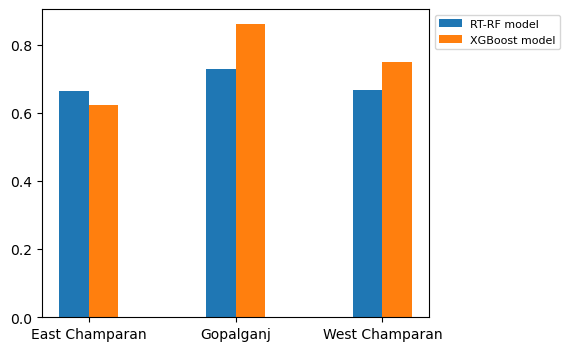

In [18]:
X_rt_rf, y_rt_rf, X_xgboost, y_xgboost = [], [], [], []


for i, data in stat_df_rt_rf.iterrows():
    X_rt_rf.append(i+1-0.1)
    y_rt_rf.append(data['Test_Pearson_R'])

for i, data in stat_df_xgboost.iterrows():
    X_xgboost.append(i+1+0.1)
    y_xgboost.append(data['Test_Pearson_R'])

width=0.2
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_rt_rf, y_rt_rf, width, label='RT-RF model')
plt.bar(X_xgboost, y_xgboost, width, label='XGBoost model')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(bbox_to_anchor=(1.0,1.0), fontsize=8, loc='upper left')

From the graph, Test RMSE, Test Pearson R values, we can conclude that XGBoost model performs better than the RT_RF sparse embedding model

## Comparison between different data imputation techniques

### XGBoost

In [19]:
methods = ['knn', 'mean', 'iterative']

for method in methods:
    if method == 'knn':
        stat_df_knn = pd.DataFrame(region_wise_stat(df.copy(deep=True), method=method, split_type='lat_long'))
    elif method == 'mean':
        stat_df_mean = pd.DataFrame(region_wise_stat(df.copy(deep=True), method=method, split_type='lat_long'))
    elif method == 'iterative':
        stat_df_iterative = pd.DataFrame(region_wise_stat(df.copy(deep=True), method=method, split_type='lat_long'))

In [20]:
stat_df_knn

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,12.063877,0.944067,34.595188,0.740465
1,Gopalganj_data,12.038710,0.957794,29.745185,0.874520
2,West_Champaran_data,9.743359,0.951583,40.732786,0.743686


In [21]:
stat_df_mean

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,12.827425,0.929060,28.841545,0.765053
1,Gopalganj_data,11.064230,0.965379,29.412658,0.871657
2,West_Champaran_data,9.297576,0.952365,38.808625,0.763000


In [22]:
stat_df_iterative

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,11.209987,0.939528,33.453514,0.781738
1,Gopalganj_data,9.027831,0.972224,34.113403,0.833213
2,West_Champaran_data,12.711593,0.937964,28.572078,0.747772


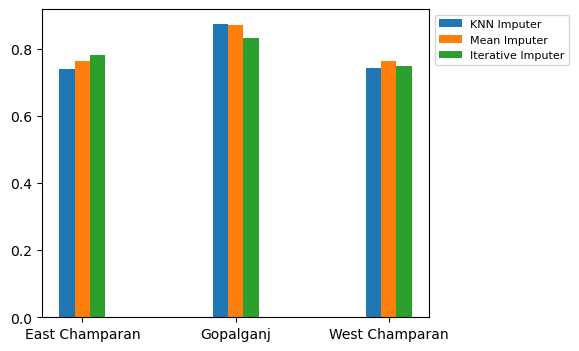

In [23]:
X_knn, y_knn, X_mean, y_mean, X_iterative, y_iterative = [], [], [], [], [], []

for method in methods:
        if method == 'knn':
            for i, data in stat_df_knn.iterrows():
                X_knn.append(i+1-0.1)
                y_knn.append(data['Test_Pearson_R'])
        elif method == 'mean':
            for i, data in stat_df_mean.iterrows():
                X_mean.append(i+1)
                y_mean.append(data['Test_Pearson_R'])
        elif method == 'iterative':
            for i, data in stat_df_iterative.iterrows():
                X_iterative.append(i+1+0.1)
                y_iterative.append(data['Test_Pearson_R'])

width=0.1
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_knn, y_knn, width, label='KNN Imputer')
plt.bar(X_mean, y_mean, width, label='Mean Imputer')
plt.bar(X_iterative, y_iterative, width, label='Iterative Imputer')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(bbox_to_anchor=(1.0,1.0), fontsize=8, loc='upper left')

### RT_RF

In [24]:
methods = ['knn', 'mean', 'iterative']

for method in methods:
    if method == 'knn':
        stat_df_knn = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', method=method, split_type='lat_long'))
    elif method == 'mean':
        stat_df_mean = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', method=method, split_type='lat_long'))
    elif method == 'iterative':
        stat_df_iterative = pd.DataFrame(region_wise_stat(df.copy(deep=True), model_type='rt_rf', method=method, split_type='lat_long'))

In [25]:
stat_df_knn

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,22.250924,0.866305,34.670208,0.660334
1,Gopalganj_data,23.054672,0.896471,40.339094,0.687976
2,West_Champaran_data,24.953810,0.853574,31.540167,0.662899


In [26]:
stat_df_mean

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,29.555493,0.823811,25.949278,0.667318
1,Gopalganj_data,24.531586,0.899338,37.798443,0.732349
2,West_Champaran_data,20.387260,0.873847,42.572713,0.667770


In [27]:
stat_df_iterative

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,22.122068,0.870853,34.927397,0.633943
1,Gopalganj_data,23.293410,0.895590,42.304251,0.708661
2,West_Champaran_data,26.272916,0.858708,29.312275,0.643431


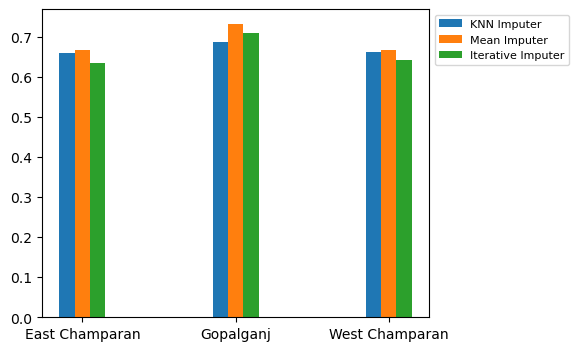

In [28]:
X_knn, y_knn, X_mean, y_mean, X_iterative, y_iterative = [], [], [], [], [], []

for method in methods:
        if method == 'knn':
            for i, data in stat_df_knn.iterrows():
                X_knn.append(i+1-0.1)
                y_knn.append(data['Test_Pearson_R'])
        elif method == 'mean':
            for i, data in stat_df_mean.iterrows():
                X_mean.append(i+1)
                y_mean.append(data['Test_Pearson_R'])
        elif method == 'iterative':
            for i, data in stat_df_iterative.iterrows():
                X_iterative.append(i+1+0.1)
                y_iterative.append(data['Test_Pearson_R'])

width=0.1
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_knn, y_knn, width, label='KNN Imputer')
plt.bar(X_mean, y_mean, width, label='Mean Imputer')
plt.bar(X_iterative, y_iterative, width, label='Iterative Imputer')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(bbox_to_anchor=(1.0,1.0), fontsize=8, loc='upper left')

From both the graphs above, the results seem a bit inconclusive towards providing the best imputer method

## Comparison between Random, Latlong and Timestamp splits

In [29]:
split_types = ['random', 'lat_long', 'timestamp']

for split_type in split_types:
    if split_type == 'random':
        stat_df_random = pd.DataFrame(region_wise_stat(df.copy(deep=True), split_type=split_type, model_type='xg_boost'))
    elif split_type == 'lat_long':
        stat_df_latlong = pd.DataFrame(region_wise_stat(df.copy(deep=True), split_type=split_type, model_type='xg_boost'))
    elif split_type == 'timestamp':
        stat_df_timestamp = pd.DataFrame(region_wise_stat(df.copy(deep=True), split_type=split_type, model_type='xg_boost'))

In [30]:
stat_df_random

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,14.058284,0.930725,24.010883,0.863105
1,Gopalganj_data,11.956674,0.959551,24.608094,0.916157
2,West_Champaran_data,12.279118,0.933810,28.004027,0.854842


In [31]:
stat_df_latlong

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,13.048803,0.935865,28.364734,0.837588
1,Gopalganj_data,10.713380,0.969543,27.244752,0.865796
2,West_Champaran_data,9.592530,0.950155,41.830215,0.781710


In [32]:
stat_df_timestamp

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,12.178787,0.932837,26.889867,0.844780
1,Gopalganj_data,11.457537,0.959889,23.840017,0.908685
2,West_Champaran_data,11.639187,0.937575,28.807339,0.810037


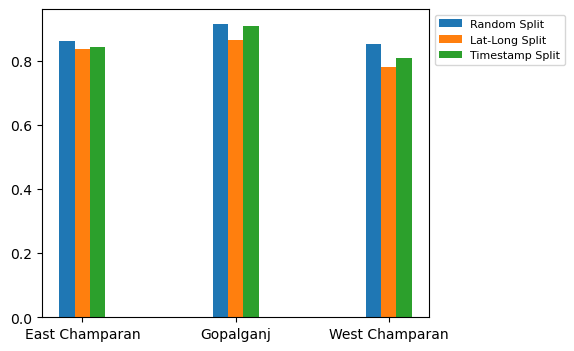

In [33]:
X_random, y_random, X_latlong, y_latlong, X_timestamp, y_timestamp = [], [], [], [], [], []

for split_type in split_types:
        if split_type == 'random':
            for i, data in stat_df_random.iterrows():
                X_random.append(i+1-0.1)
                y_random.append(data['Test_Pearson_R'])
        elif split_type == 'lat_long':
            for i, data in stat_df_latlong.iterrows():
                X_latlong.append(i+1)
                y_latlong.append(data['Test_Pearson_R'])
        elif split_type == 'timestamp':
            for i, data in stat_df_timestamp.iterrows():
                X_timestamp.append(i+1+0.1)
                y_timestamp.append(data['Test_Pearson_R'])

width=0.1
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_random, y_random, width, label='Random Split')
plt.bar(X_latlong, y_latlong, width, label='Lat-Long Split')
plt.bar(X_timestamp, y_timestamp, width, label='Timestamp Split')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(bbox_to_anchor=(1.0,1.0), fontsize=8, loc='upper left')

## Comparison between complete data, exclude timestamp

In [34]:
stat_df_complete = pd.DataFrame(region_wise_stat(df.copy(deep=True), split_type='timestamp'))
stat_df_ex_timestamp = pd.DataFrame(region_wise_stat(df.copy(deep=True), split_type='timestamp', include_timestamp=False))

In [35]:
stat_df_complete

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,12.178787,0.932837,26.889867,0.844780
1,Gopalganj_data,11.457537,0.959889,23.840017,0.908685
2,West_Champaran_data,11.639187,0.937575,28.807339,0.810037


In [36]:
stat_df_ex_timestamp

,Region,Train_RMSE,Train_Pearson_R,Test_RMSE,Test_Pearson_R
0,East_Champaran_data,25.455513,0.702423,38.541264,0.506289
1,Gopalganj_data,29.532964,0.749276,47.839583,0.582588
2,West_Champaran_data,22.011712,0.748873,39.173796,0.438220


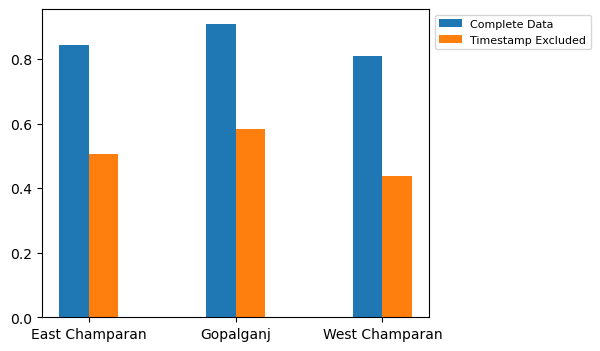

In [40]:
X_complete, y_complete, X_ex_timestamp, y_ex_timestamp = [], [], [], []

for i, data in stat_df_complete.iterrows():
    X_complete.append(i+1-0.1)
    y_complete.append(data['Test_Pearson_R'])

for i, data in stat_df_ex_timestamp.iterrows():
    X_ex_timestamp.append(i+1+0.1)
    y_ex_timestamp.append(data['Test_Pearson_R'])

width=0.2
X = [val for val in range(1, 4)]

plt.rcParams["figure.figsize"] = (5,4)
plt.bar(X_complete, y_complete, width, label='Complete Data')
plt.bar(X_ex_timestamp, y_ex_timestamp, width, label='Timestamp Excluded')
plt.xticks(X, ['East Champaran', 'Gopalganj', 'West Champaran'])
plt.legend(bbox_to_anchor=(1.0,1.0), fontsize=8, loc='upper left')